In [ ]:
!pip install keras-transformer
import keras_transformer
from keras_transformer import get_model,decode

In [ ]:
%cd /content/drive/MyDrive/
import pandas as pd
with open('min-ind3.txt','r') as file:
  source_tokens = []
  target_tokens = []
  for f in file.readlines():
    f = f.replace('\n','')
    #print(list(f))
    ls_source = []
    ls_source.append(f.split(',')[0])
    source_tokens.append(ls_source)
    ls_target = []
    ls_target.append(f.split(',')[1])
    target_tokens.append(ls_target)

/content/drive/MyDrive


In [ ]:
## Here to test we are using just 10 samples out of 14013 samples ##
## TO TRAIN ON WHOLE DATA IT WILL TAKE TIME SO COMMENT DOWN BELOW TWO LINES TO TRAIN ON WHOLE DATA ##
### Split target and source tokens ###
import sklearn
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(source_tokens,target_tokens,test_size = 0.2)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.25)
target_tokens = x_train[:10]
source_tokens = y_train[:10]

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder-Input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder-Token-Embedding (Embedd [(None, None, 32), ( 416         Encoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Embedding (TrigPosEmbed (None, None, 32)     0           Encoder-Token-Embedding[0][0]    
__________________________________________________________________________________________________
Encoder-1-MultiHeadSelfAttentio (None, None, 32)     4224        Encoder-Embedding[0][0]          
____________________________________________________________________________________________

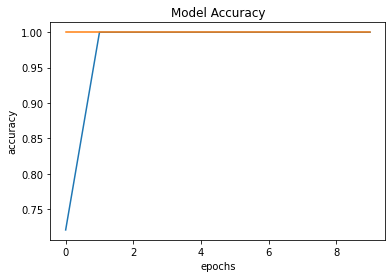

INFO:tensorflow:Assets written to: char_transformer_f/assets


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
%matplotlib inline
#from sklearn.model_selection import KFold
#kf = KFold(n_splits=5)
# Generate dictionaries
def build_token_dict(token_list):
    token_dict = {
        '<PAD>': 0,
        '<START>': 1,
        '<END>': 2,
    }
    for tokens in token_list:
        for token in tokens:
            if token not in token_dict:
                token_dict[token] = len(token_dict)
    return token_dict

source_token_dict = build_token_dict(source_tokens)
target_token_dict = build_token_dict(target_tokens)
target_token_dict_inv = {v: k for k, v in target_token_dict.items()}

# Add special tokens
encode_tokens = [['<START>'] + tokens + ['<END>'] for tokens in source_tokens]
decode_tokens = [['<START>'] + tokens + ['<END>'] for tokens in target_tokens]
output_tokens = [tokens + ['<END>', '<PAD>'] for tokens in target_tokens]

# Padding
source_max_len = max(map(len, encode_tokens))
target_max_len = max(map(len, decode_tokens))

encode_tokens = [tokens + ['<PAD>'] * (source_max_len - len(tokens)) for tokens in encode_tokens]
decode_tokens = [tokens + ['<PAD>'] * (target_max_len - len(tokens)) for tokens in decode_tokens]
output_tokens = [tokens + ['<PAD>'] * (target_max_len - len(tokens)) for tokens in output_tokens]

encode_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in encode_tokens]
decode_input = [list(map(lambda x: target_token_dict[x], tokens)) for tokens in decode_tokens]
decode_output = [list(map(lambda x: [target_token_dict[x]], tokens)) for tokens in output_tokens]

# Build & fit model
model = get_model(
    token_num=max(len(source_token_dict), len(target_token_dict)),
    embed_dim=32,
    encoder_num=2,
    decoder_num=2,
    head_num=4,
    hidden_dim=128,
    dropout_rate=0.05,
    use_same_embed=False,  # Use different embeddings for different languages
)
model.compile('adam', 'sparse_categorical_crossentropy',metrics=["accuracy"])
model.summary()

#encode_input_val = pd

results = model.fit(
    x=[np.array(encode_input * 1024), np.array(decode_input * 1024)],
    y=np.array(decode_output * 1024),
    epochs=10,
    batch_size=32,
    validation_split=0.25
)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
#plt.legend(['train','val'],loc='upper right')
plt.title('Model Accuracy')
plt.show()

model.save('char_transformer_f')


In [ ]:
# Testing data #
source_tokens = x_test[:10]
target_tokens = y_test[:10]
source_token_dict = build_token_dict(source_tokens)
target_token_dict = build_token_dict(target_tokens)
target_token_dict_inv = {v: k for k, v in target_token_dict.items()}

# Add special tokens
encode_tokens = [['<START>'] + tokens + ['<END>'] for tokens in source_tokens]
decode_tokens = [['<START>'] + tokens + ['<END>'] for tokens in target_tokens]
output_tokens = [tokens + ['<END>', '<PAD>'] for tokens in target_tokens]

# Padding
source_max_len = max(map(len, encode_tokens))
target_max_len = max(map(len, decode_tokens))

encode_tokens = [tokens + ['<PAD>'] * (source_max_len - len(tokens)) for tokens in encode_tokens]
decode_tokens = [tokens + ['<PAD>'] * (target_max_len - len(tokens)) for tokens in decode_tokens]
output_tokens = [tokens + ['<PAD>'] * (target_max_len - len(tokens)) for tokens in output_tokens]

encode_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in encode_tokens]
decode_input = [list(map(lambda x: target_token_dict[x], tokens)) for tokens in decode_tokens]
decode_output = [list(map(lambda x: [target_token_dict[x]], tokens)) for tokens in output_tokens]


In [ ]:
#model = keras.models.load_model('char_transformer_f')
# Predict
decoded = decode(
    model,
    encode_input,
    start_token=target_token_dict['<START>'],
    end_token=target_token_dict['<END>'],
    pad_token=target_token_dict['<PAD>'],
)
print(''.join(map(lambda x: target_token_dict_inv[x], decoded[0][1:-1]))) # first word in list of source tokens
print(''.join(map(lambda x: target_token_dict_inv[x], decoded[9][1:-1]))) # second word in list of source tokens

asteroid
menorehkan
